# 文本分类实例 - 中文评价情绪预测（Text Classification Example - Chinese Evaluation Emotion Prediction）

### 数据集: 某外卖平台收集的用户评价，正向 4000 条，负向 约 8000 条

## 字段说明

| 字段 | 说明 |
| ---- | ---- |
| label | 1 表示正向评论，0 表示负向评论 |
| review | 评论内容 |

安装 jieba 和 pandas

     pip install pandas jieba sklearn -i https://pypi.doubanio.com/simple

In [1]:
import torch
import torchtext
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import jieba
import matplotlib.pyplot as plt
%matplotlib inline

## 数据读取和观察

In [2]:
# 读取数据
data = pd.read_csv('./dataset/waimai_10k.csv')

In [3]:
# 查看数据
data.head()

,label,review
0,1,很快，好吃，味道足，量大
1,1,没有送水没有送水没有送水
2,1,非常快，态度好。
3,1,方便，快捷，味道可口，快递给力
4,1,菜味道很棒！送餐很及时！


In [4]:
# 查看数据集信息
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11987 entries, 0 to 11986
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   11987 non-null  int64 
 1   review  11987 non-null  object
dtypes: int64(1), object(1)
memory usage: 187.4+ KB


In [5]:
# 查看数据集标签分布
data.label.value_counts()

0    7987
1    4000
Name: label, dtype: int64

## 对文本数据进行分词

In [6]:
# 文本处理函数，去除标点符号，分词
def pre_text(text):
    text = text.replace('！', '').replace('，', '').replace('。', '')
    return jieba.lcut(text)

In [7]:
# 对文本进行预处理、分词
data['review'] = data.review.apply(pre_text)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\LIUBAI~1\AppData\Local\Temp\jieba.cache
Loading model cost 0.669 seconds.
Prefix dict has been built successfully.


In [8]:
# 查看分词后的数据
data.review

0                                      [很快, 好吃, 味道, 足量, 大]
1                                 [没有, 送水, 没有, 送水, 没有, 送水]
2                                           [非常, 快, 态度, 好]
3                                 [方便快捷, 味道, 可口, 快, 递给, 力]
4                                   [菜, 味道, 很棒, 送餐, 很, 及时]
                               ...                        
11982                   [以前, 几乎, 天天, 吃, 现在, 调料, 什么, 都, 不放]
11983    [昨天, 订, 凉皮, 两份, 什么, 调料, 都, 没有, 放, 就, 放, 了, 点, ...
11984                                  [凉皮, 太辣, ,, 吃不下, 都]
11985                                [本来, 迟到, 了, 还, 自己, 点]
11986    [肉夹馍, 不错, 羊肉, 泡馍, 酱肉, 包, 很, 一般, 凉面, 没, 想象, 中, ...
Name: review, Length: 11987, dtype: object

## 创建词表（vocab）

In [9]:
# 将分词后的所有词添加到一个array中后，统计词频
word_count = pd.value_counts(np.concatenate(data.review.values))
# 过滤掉词频小于3的词
word_count = word_count[word_count > 2]

# 查看词频统计结果
word_count

了       9397
的       7836
,       4212
很       2257
都       2192
        ... 
精神         3
停不下来       3
过敏         3
要不然        3
筋道         3
Length: 3870, dtype: int64

In [10]:
# 获取词表长度
max_word = len(word_count) + 1
max_word

3871

In [11]:
# 将词频统计结果转换为列表并编码
word_list = list(word_count.index)
# 查看编码后的词列表
word_list.index('好吃')

12

In [12]:
# 将词列表转换为字典，使用位置进行编码
word_index =  dict((word, word_list.index(word) + 1) for word in word_list)
word_index

{'了': 1,
 '的': 2,
 ',': 3,
 '很': 4,
 '都': 5,
 '是': 6,
 '我': 7,
 '也': 8,
 '不': 9,
 '还': 10,
 '好': 11,
 '味道': 12,
 '好吃': 13,
 '送餐': 14,
 '吃': 15,
 '送': 16,
 '就': 17,
 '不错': 18,
 '小时': 19,
 '给': 20,
 '没有': 21,
 '没': 22,
 '？': 23,
 '点': 24,
 '送到': 25,
 '说': 26,
 '…': 27,
 '速度': 28,
 '就是': 29,
 '等': 30,
 '才': 31,
 '外卖': 32,
 '到': 33,
 '太': 34,
 '快': 35,
 '难吃': 36,
 '在': 37,
 '一个': 38,
 '啊': 39,
 '菜': 40,
 '一般': 41,
 '送来': 42,
 '太慢': 43,
 '非常': 44,
 '还是': 45,
 '时间': 46,
 '饭': 47,
 '凉': 48,
 '多': 49,
 '和': 50,
 '有': 51,
 '有点': 52,
 '吧': 53,
 '很快': 54,
 '可以': 55,
 '个': 56,
 '慢': 57,
 '配送': 58,
 '百度': 59,
 '～': 60,
 '特别': 61,
 '但是': 62,
 '两个': 63,
 '态度': 64,
 '粥': 65,
 '这': 66,
 '要': 67,
 '而且': 68,
 '不是': 69,
 '什么': 70,
 '肉': 71,
 '少': 72,
 '打电话': 73,
 '电话': 74,
 '饼': 75,
 '让': 76,
 '人': 77,
 '服务': 78,
 '再': 79,
 '分钟': 80,
 '你': 81,
 '吗': 82,
 '又': 83,
 '小哥': 84,
 '怎么': 85,
 '能': 86,
 '以后': 87,
 '差': 88,
 '快递': 89,
 '东西': 90,
 '结果': 91,
 '米饭': 92,
 '量': 93,
 '这么': 94,
 '感觉': 95,
 '~': 96,
 '里':

## 文本数据预处理

In [13]:
# 将文本转换为编码后的数字列表
text = data.review.apply(lambda x: [word_index.get(word, 0) for word in x])
text

0                                     [54, 13, 12, 0, 113]
1                           [21, 3168, 21, 3168, 21, 3168]
2                                         [44, 35, 64, 11]
3                          [3112, 12, 1388, 35, 2634, 517]
4                                [40, 12, 392, 14, 4, 290]
                               ...                        
11982          [229, 560, 1455, 15, 287, 960, 70, 5, 2151]
11983    [618, 110, 379, 338, 70, 960, 5, 21, 198, 17, ...
11984                               [379, 955, 3, 2642, 5]
11985                           [381, 376, 1, 10, 154, 24]
11986    [565, 18, 887, 1678, 3146, 634, 4, 41, 767, 22...
Name: review, Length: 11987, dtype: object

In [14]:
# 获取文本的最大长度
maxlen = max(len(x) for x in text)
print("Max length of text: ", maxlen)

Max length of text:  279


In [15]:
# 设置文本长度为20
text_len = 20
# 对文本进行填充或截断，使其长度为20
pad_text = [l + (text_len-len(l))*[0] if len(l)<=text_len else l[ :text_len] for l in text]
# 转换为nparray
pad_text = np.array(pad_text)
# 查看填充后的文本形状
print("Shape of padded text: ", pad_text.shape)

Shape of padded text:  (11987, 20)


## 标签数据预处理

In [16]:
# 获取标签列表
labels = data.label.values
# 查看标签列表形状
print("Shape of labels: ", labels.shape)

Shape of labels:  (11987,)


## 划分数据集

In [17]:
from sklearn.model_selection import train_test_split
# 划分数据集，使用默认的划分比例7.5：2.5
x_train, x_test, y_train, y_test = train_test_split(pad_text, labels)
x_train.shape, x_test.shape, y_train.shape

((8990, 20), (2997, 20), (8990,))

## 创建Dataset

In [18]:
# 定义一个自定义的数据集类
class Waimai_dataset(torch.utils.data.Dataset):
    def __init__(self, text_list, label_list):
        self.text_list = text_list
        self.label_list = label_list
        
    def __getitem__(self, index):
        text = torch.LongTensor(self.text_list[index])
        label = self.label_list[index]
        return text, label

    def __len__(self):
        return len(self.text_list)

In [19]:
# 创建训练集和测试集
train_ds = Waimai_dataset(x_train, y_train)
test_ds = Waimai_dataset(x_test, y_test)

In [20]:
# 创建数据加载器
BTACH_SIZE = 256
train_dl = torch.utils.data.DataLoader(
                                       train_ds,
                                       batch_size=BTACH_SIZE,
                                       shuffle=True
)
test_dl = torch.utils.data.DataLoader(
                                       test_ds,
                                       batch_size=BTACH_SIZE
)

## 模型构建

In [21]:
embeding_dim = 100
hidden_size = 200

In [22]:
class Net(nn.Module):
    def __init__(self, max_word, embeding_dim, hidden_size):
        super(Net, self).__init__()
        # Embedding 把文本映射为一个密集向量，将每一个单词映射为一个100维的向量
        self.em = nn.Embedding(max_word, embeding_dim)   # 200*batch*100
        self.rnn = nn.LSTM(embeding_dim, hidden_size)     # batch*300
        self.fc1 = nn.Linear(hidden_size, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, inputs):
        # bz = inputs.shape[1]
        # h0 = torch.zeros((1, bz, hidden_size)).cuda()
        # c0 = torch.zeros((1, bz, hidden_size)).cuda()
        x = self.em(inputs)
        # r_o, _ = self.rnn(x, (h0, c0))
        r_o, _ = self.rnn(x)
        r_o = r_o[-1]
        x = F.dropout(F.relu(self.fc1(r_o)))
        x = self.fc2(x)
        return x

## 模型训练

In [ ]:
# 参数整理
model = Net(max_word, embeding_dim, hidden_size)
learn_rate = 0.001
epochs = 20
train_dl = train_dl
test_dl = test_dl

# 训练前准备，定义模型、损失函数、优化器
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # 判断是否有GPU，如果有则使用GPU，否则使用CPU
model.to(device) # 将已实例化的模型移动到GPU上

loss_fn = torch.nn.CrossEntropyLoss()  # 损失函数，交叉熵损失函数，使用未激活的输出作为输入，内置了softmax函数为激活函数，输出为每个类别的概率
opt = torch.optim.Adam(model.parameters(), lr=learn_rate) # 优化器，Adam优化器

# 通用训练模板，输入模型、训练数据、测试数据，返回loss和acc变化
# 训练函数
def train(train_dl, model, loss_fn, opt):
    size = len(train_dl.dataset) # 获取数据集的大小
    num_batches = len(train_dl) # 获取数据集的批次数量

    train_loss = 0.0 # 训练集损失
    train_acc = 0.0 # 训练集准确率

    for x, y in train_dl: # 遍历数据集
        x = x.permute(1, 0) # 将数据从(batch_size, seq_len)转换为(seq_len, batch_size)
        y = y.long()      # 将标签转换为long类型
        x, y = x.to(device), y.to(device) # 将数据移动到GPU上

        pred = model(x) # 前向传播
        loss = loss_fn(pred, y) # 计算损失

        opt.zero_grad() # 梯度清零
        loss.backward() # 反向传播
        opt.step() # 更新参数

        with torch.no_grad(): # 不计算梯度
            train_loss += loss.item() # 计算损失
            train_acc += (pred.argmax(dim=1) == y).type(torch.float).sum().item() # 计算准确率

    train_loss /= num_batches # 计算平均损失
    train_acc /= size # 计算平均准确率

    return train_loss, train_acc

# 测试函数
def test(test_dl, model, loss_fn):
    size = len(test_dl.dataset) # 获取数据集的大小
    num_batches = len(test_dl) # 获取数据集的批次数量

    test_loss = 0.0 # 测试集损失
    test_acc = 0.0 # 测试集准确率

    with torch.no_grad(): # 不计算梯度
        for x, y in test_dl:  # 遍历数据集
            x = x.permute(1, 0) # 将数据从(batch_size, seq_len)转换为(seq_len, batch_size)
            y = y.long()      # 将标签转换为long类型
            x, y = x.to(device), y.to(device) # 将数据移动到GPU上

            pred = model(x) # 前向传播
            loss = loss_fn(pred, y) # 计算损失
            test_loss += loss.item() # 计算损失
            test_acc += (pred.argmax(dim=1) == y).type(torch.float).sum().item() # 计算准确率

    test_loss /= num_batches # 计算平均损失
    test_acc /= size # 计算平均准确率

    return test_loss, test_acc

# 训练函数
def fit(epochs, model, train_dl, test_dl, loss_fn, opt):
    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []

    print_template = 'Epoch: {}, Train Loss: {:.4f}, Train Acc: {:.2f}%, Test Loss: {:.4f}, Test Acc: {:.2f}%'


    for epoch in range(epochs):
        model.train() # 设置模型为训练模式，启用dropout层
        epoch_train_loss, epoch_train_acc = train(train_dl, model, loss_fn, opt)
        model.eval() # 设置模型为评估预测模式，禁用dropout层
        epoch_test_loss, epoch_test_acc = test(test_dl, model, loss_fn)

        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_acc)
        test_loss.append(epoch_test_loss)
        test_acc.append(epoch_test_acc)

        print(print_template.format(epoch, epoch_train_loss, epoch_train_acc * 100, epoch_test_loss, epoch_test_acc * 100))

    return train_loss, train_acc, test_loss, test_acc

# 训练
train_loss, train_acc, test_loss, test_acc = fit(epochs, model, train_dl, test_dl, loss_fn, opt)

Epoch: 0, Train Loss: 0.6195, Train Acc: 66.35%, Test Loss: 0.5952, Test Acc: 73.81%
Epoch: 1, Train Loss: 0.4851, Train Acc: 77.53%, Test Loss: 0.4459, Test Acc: 81.58%
Epoch: 2, Train Loss: 0.3792, Train Acc: 84.82%, Test Loss: 0.3793, Test Acc: 84.52%
Epoch: 3, Train Loss: 0.3252, Train Acc: 87.68%, Test Loss: 0.3470, Test Acc: 86.29%
Epoch: 4, Train Loss: 0.2976, Train Acc: 89.13%, Test Loss: 0.3531, Test Acc: 86.25%
Epoch: 5, Train Loss: 0.2636, Train Acc: 90.22%, Test Loss: 0.3496, Test Acc: 87.02%
Epoch: 6, Train Loss: 0.2489, Train Acc: 91.21%, Test Loss: 0.3402, Test Acc: 86.12%
Epoch: 7, Train Loss: 0.2204, Train Acc: 92.50%, Test Loss: 0.3327, Test Acc: 87.32%
Epoch: 8, Train Loss: 0.1975, Train Acc: 93.57%, Test Loss: 0.3382, Test Acc: 87.35%
Epoch: 9, Train Loss: 0.1770, Train Acc: 94.16%, Test Loss: 0.3672, Test Acc: 86.69%
Epoch: 10, Train Loss: 0.1519, Train Acc: 94.84%, Test Loss: 0.4093, Test Acc: 87.52%
Epoch: 11, Train Loss: 0.1337, Train Acc: 95.70%, Test Loss: 0.3

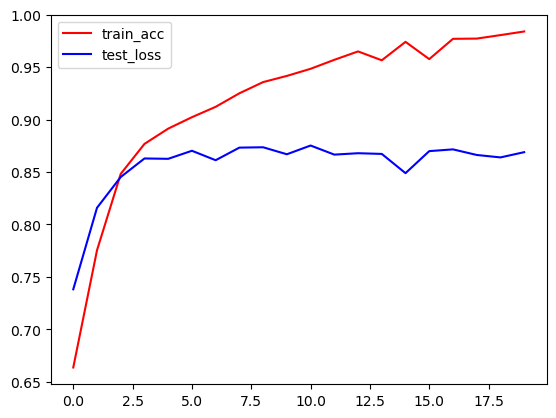

In [ ]:
plt.plot(range(epochs), train_acc, c='r', label='train_acc')
plt.plot(range(epochs), test_acc, c='b', label='test_loss')
plt.legend()

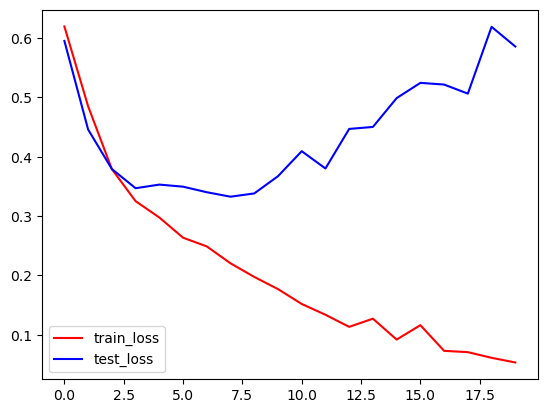

In [ ]:
plt.plot(range(epochs), train_loss, c='r', label='train_loss')
plt.plot(range(epochs), test_loss, c='b', label='test_loss')
plt.legend()